# Améliorez le produit IA de votre start-up

In [47]:
import warnings
warnings.simplefilter(action='ignore')

### basic libs

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
import operator
import pickle

# api

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# text 

from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# image

import tensorflow as tf
from sklearn.manifold import TSNE

pyLDAvis.enable_notebook()

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

debug = 1


### Requêtes à l'API GraphQL

In [48]:
with open("api.key", "r") as f:
    api_key = f.readline()


header = {'Authorization': f'bearer {api_key}',
         'Content-Type': 'application/json'}

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.yelp.com/v3/graphql", headers=header, use_json=True)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)


In [49]:
def get_new_reviews(city):

    df_reviews = pd.DataFrame(columns=['text', 'rating'])
    
    offset = 50
    
    for chunk in range(4):
        query = '''
        {
          search(term:"restaurants",
                 limit : 50,
                 offset: '''+str(offset*chunk)+''',
                 location:"''' + city + '''") {
            business {
              reviews {
                text
                rating
              }
            }
          }
        }
        '''
        query = gql(query)
        result = client.execute(query)
    
        for business in result["search"]["business"]:
            for review in business["reviews"]:
                df_reviews = df_reviews.append(review, ignore_index=True)
                
    df_reviews = df_reviews.dropna()

    df_reviews.to_csv('new_reviews.csv')
    
    print(f"Got {df_reviews.shape[0]} reviews")
    
    print(df_reviews.head())
    
# get_new_reviews("san francisco")

### Analyse des reviews

In [50]:
if debug:
    nrows = 500000
else:
    nrows = None

filename = './preprocessed_reviews.csv'

comments = pd.read_csv(filename, nrows=nrows)

comments.head()

,tokenized_text
0,stay mani marriott renaiss marriott huge front...
1,cool chill bunch neanderth bouncer hop steroid...
2,set perfect adequ close dine chain chili victo...
3,correct crappi inconsist gone hill steadili month
4,bolt follow fanni fabric close fanni select sm...


In [51]:
computed = 1

models_best_coherence_score = {}

comments["tokenized_text"] = comments["tokenized_text"].apply(lambda x: x.split())

def list_list_to_list(x):
    return [item for sublist in x for item in sublist]

def clean_data_rdy(data_ready_for_model):
    dictionary = gensim.corpora.Dictionary(data_ready_for_model)
    count = 0

    for k, v in dictionary.iteritems():
        count += 1
        if count > 10:
            break

    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary

def plot_coherence_values(df_coherence):
        fig, ax = plt.subplots(figsize=(12,6))
        sns.set_color_codes("pastel")
        s = sns.lineplot(ax = ax, x = 'nb_of_topics', y = 'coherence_value', data = df_coherence)
        plt.title('Coherence score evolution with number of topics')
        plt.show()

    
def LDA_TF_IDF(start, limit):
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    coherence = []
    for k in list(range(start, limit, 1)):         
        ldamodel_tf_idf = gensim.models.LdaMulticore(corpus_tfidf,
                                                     num_topics=k,
                                                     id2word = id2word,
                                                     iterations=200,
                                                     passes=2,
                                                     workers=4)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel_tf_idf, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA_TF_IDF'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                                 num_topics=best_num_topic,
                                                 id2word=id2word,
                                                 iterations=200,
                                                 passes=2,
                                                 workers=4)
    #visualization
    visualisation = gensimvis.prepare(lda_model_tfidf, corpus, id2word)

    return lda_model_tfidf, visualisation
    
        
def LDA(start, limit):       
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    coherence = []
    for k in list(range(start, limit, 1)):
        Lda = gensim.models.ldamodel.LdaModel

        ldamodel = Lda( corpus,
                        num_topics=k,
                        id2word = id2word,
                        iterations=200)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)


    #Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics = best_num_topic,
                                                iterations=200)

    #visualization
    visualisation = gensimvis.prepare(lda_model, corpus, id2word)

    return lda_model, visualisation


#### LDA

In [52]:
def lda_coherency():
    if computed:
        with open('lda.dat', 'rb') as f:
            LDA_model = pickle.load(f)
        with open('lda_visu.dat', 'rb') as f:
            lda_visu = pickle.load(f)
    else:
        LDA_model, lda_visu = LDA(4, 8)

    for idx, topic in LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return LDA_model, lda_visu
        
LDA_model, lda_visu = lda_coherency()

Topic: 0 Word: 0.011*"phone" + 0.011*"room" + 0.009*"compani" + 0.009*"charg" + 0.008*"month" + 0.007*"hotel" + 0.007*"week" + 0.007*"appoint" + 0.007*"stay" + 0.006*"card"
Topic: 1 Word: 0.027*"hair" + 0.024*"coffe" + 0.018*"dog" + 0.016*"ice" + 0.013*"cut" + 0.011*"cream" + 0.011*"tea" + 0.008*"cup" + 0.007*"cake" + 0.007*"chocol"
Topic: 2 Word: 0.022*"car" + 0.013*"store" + 0.008*"park" + 0.007*"guy" + 0.007*"drive" + 0.007*"buy" + 0.006*"shop" + 0.006*"line" + 0.005*"help" + 0.005*"employe"
Topic: 3 Word: 0.026*"clean" + 0.019*"nail" + 0.012*"dirti" + 0.010*"done" + 0.009*"smell" + 0.009*"salon" + 0.008*"floor" + 0.008*"bathroom" + 0.008*"wash" + 0.007*"hand"
Topic: 4 Word: 0.010*"bar" + 0.008*"seat" + 0.007*"server" + 0.007*"night" + 0.006*"sit" + 0.005*"waitress" + 0.005*"final" + 0.004*"arriv" + 0.004*"leav" + 0.004*"open"
Topic: 5 Word: 0.014*"pizza" + 0.013*"fri" + 0.012*"burger" + 0.012*"chicken" + 0.011*"chees" + 0.011*"salad" + 0.010*"meal" + 0.009*"sauc" + 0.009*"cook" + 0

In [53]:
lda_visu

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.058238  0.055891       1        1  26.920213
0     -0.202867  0.120321       2        1  20.231541
2     -0.140305  0.060890       3        1  17.549816
5      0.206161  0.057770       4        1  14.491854
6      0.221162  0.067416       5        1   8.058112
3     -0.076385 -0.218142       6        1   7.157709
1      0.050472 -0.144146       7        1   5.590755, topic_info=         Term          Freq         Total Category  logprob  loglift
1799      car  86246.000000  86246.000000  Default  30.0000  30.0000
198     clean  45309.000000  45309.000000  Default  29.0000  29.0000
292      hair  33136.000000  33136.000000  Default  28.0000  28.0000
788   chicken  61189.000000  61189.000000  Default  27.0000  27.0000
644     store  51850.000000  51850.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
109      shop   5557.434391  29109.913950   Topic7  -5.4151   1.2281
1059    sweet   4746.278123  17403.409001   Topic7  -5.5728   1.5848
39      alway   5599.427515  40137.981242   Topic7  -5.4075   0.9144
310     littl   4941.922048  50374.751180   Topic7  -5.5324   0.5623
399       top   4278.310579  37096.117655   Topic7  -5.6766   0.7241

[490 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1238      2  0.999930  account
2179      2  0.081792  airport
2179      3  0.918113  airport
39        1  0.361976    alway
39        2  0.083088    alway
...     ...       ...      ...
563       5  0.000645     wing
3228      1  0.058641     wipe
3228      3  0.000485     wipe
3228      6  0.940675     wipe
3718      6  0.999723     yard

[1209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 6, 7, 4, 2])

In [54]:
def save_lda():
    with open('lda.dat', 'wb') as f:
        pickle.dump(LDA_model, f)
    with open('lda_visu.dat', 'wb') as f:
        pickle.dump(lda_visu, f)

# save_lda()

#### LDA avec TF-IDF

In [55]:
def tf_idf_lda_coherency():
    if computed:
        with open('lda_tf_idf.dat', 'rb') as f:
            TF_IDF_LDA_model = pickle.load(f)
        with open('lda_tf_idf_visu.dat', 'rb') as f:
            lda_tf_idf_visu = pickle.load(f)
    else:
        TF_IDF_LDA_model, lda_tf_idf_visu = LDA_TF_IDF(4, 8)
        
    for idx, topic in TF_IDF_LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return TF_IDF_LDA_model, lda_tf_idf_visu
        
TF_IDF_LDA_model, lda_tf_idf_visu = tf_idf_lda_coherency()

Topic: 0 Word: 0.011*"phone" + 0.011*"room" + 0.009*"compani" + 0.009*"charg" + 0.008*"month" + 0.007*"hotel" + 0.007*"week" + 0.007*"appoint" + 0.007*"stay" + 0.006*"card"
Topic: 1 Word: 0.027*"hair" + 0.024*"coffe" + 0.018*"dog" + 0.016*"ice" + 0.013*"cut" + 0.011*"cream" + 0.011*"tea" + 0.008*"cup" + 0.007*"cake" + 0.007*"chocol"
Topic: 2 Word: 0.022*"car" + 0.013*"store" + 0.008*"park" + 0.007*"guy" + 0.007*"drive" + 0.007*"buy" + 0.006*"shop" + 0.006*"line" + 0.005*"help" + 0.005*"employe"
Topic: 3 Word: 0.026*"clean" + 0.019*"nail" + 0.012*"dirti" + 0.010*"done" + 0.009*"smell" + 0.009*"salon" + 0.008*"floor" + 0.008*"bathroom" + 0.008*"wash" + 0.007*"hand"
Topic: 4 Word: 0.010*"bar" + 0.008*"seat" + 0.007*"server" + 0.007*"night" + 0.006*"sit" + 0.005*"waitress" + 0.005*"final" + 0.004*"arriv" + 0.004*"leav" + 0.004*"open"
Topic: 5 Word: 0.014*"pizza" + 0.013*"fri" + 0.012*"burger" + 0.012*"chicken" + 0.011*"chees" + 0.011*"salad" + 0.010*"meal" + 0.009*"sauc" + 0.009*"cook" + 0

In [56]:
lda_tf_idf_visu

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.058238  0.055891       1        1  26.920213
0     -0.202867  0.120321       2        1  20.231541
2     -0.140305  0.060890       3        1  17.549816
5      0.206161  0.057770       4        1  14.491854
6      0.221162  0.067416       5        1   8.058112
3     -0.076385 -0.218142       6        1   7.157709
1      0.050472 -0.144146       7        1   5.590755, topic_info=         Term          Freq         Total Category  logprob  loglift
1799      car  86246.000000  86246.000000  Default  30.0000  30.0000
198     clean  45309.000000  45309.000000  Default  29.0000  29.0000
292      hair  33136.000000  33136.000000  Default  28.0000  28.0000
788   chicken  61189.000000  61189.000000  Default  27.0000  27.0000
644     store  51850.000000  51850.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
109      shop   5557.434391  29109.913950   Topic7  -5.4151   1.2281
1059    sweet   4746.278123  17403.409001   Topic7  -5.5728   1.5848
39      alway   5599.427515  40137.981242   Topic7  -5.4075   0.9144
310     littl   4941.922048  50374.751180   Topic7  -5.5324   0.5623
399       top   4278.310579  37096.117655   Topic7  -5.6766   0.7241

[490 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1238      2  0.999930  account
2179      2  0.081792  airport
2179      3  0.918113  airport
39        1  0.361976    alway
39        2  0.083088    alway
...     ...       ...      ...
563       5  0.000645     wing
3228      1  0.058641     wipe
3228      3  0.000485     wipe
3228      6  0.940675     wipe
3718      6  0.999723     yard

[1209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 6, 7, 4, 2])

In [57]:
def save_lda_tf_idf():
    with open('lda_tf_idf.dat', 'wb') as f:
        pickle.dump(LDA_model, f)
    with open('lda_tf_idf_visu.dat', 'wb') as f:
        pickle.dump(lda_visu, f)

# save_lda_tf_idf()

### Analyse des photos

#### Préparation du dataset tensorflow

In [11]:
nrows = 131072

n_epochs = 20

test_nrows = 2048

val_nrows = 2048

batch_size = 16

steps_per_epoch = nrows // (batch_size * 1)

AUTOTUNE = tf.data.AUTOTUNE

In [12]:
test_size = 2048

val_size = 2048

BUFFER_SIZE = 1000

lbls = ['interior', 'outside', 'menu', 'food', 'drink']

def get_path(name):
    return os.path.join("preprocessed_imgs", f"{name}.jpg")

def train_test_img_split():
    pictures = pd.read_json("photos.json", lines=True)[["photo_id", "label"]]
    pictures["path"] = pictures["photo_id"].apply(get_path)
    pictures = pictures[["path", "label"]]
    pictures = pictures.sample(frac=1) # shuffle
    pictures["label"] = pictures["label"].apply(lambda x:  {'interior': 0, 'outside': 1, 'menu': 2, 'food': 3, 'drink': 4}[x])
    test_df = pictures.head(test_size)
    pictures = pictures.tail(pictures.shape[0] - test_size)
    val_df = pictures.head(val_size)
    pictures = pictures.tail(pictures.shape[0] - val_size)
    test_df.to_csv('photos_test.csv', index=False)
    val_df.to_csv('photos_val.csv', index=False)
    pictures.to_csv('photos_train.csv', index=False)
    
def load_img(path, tgt):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    tgt = tf.reshape(tgt, [1])
    return img, tgt

def set_shapes(image, label):
    image.set_shape((224, 224, 3))
    return image, label

# train_test_img_split()

In [13]:
train_df = pd.read_csv('photos_train.csv')
train_df = train_df.sample(frac=1)
train_df = train_df.head(nrows)
test_df = pd.read_csv('photos_test.csv')
test_df = test_df.head(test_nrows)
val_df = pd.read_csv('photos_val.csv')
val_df = val_df.head(val_nrows)

In [15]:
cmap = cm.get_cmap('tab20')

def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
def tsne(mdl, lr=200.0, pp=40):
    target = [*map(lambda x:int(x[0]), list(np.concatenate([y for x, y in test_ds], axis=0)))]
    model_2 = tf.keras.models.Sequential(mdl.layers[:-1])
    res = model_2.predict(test_ds)
    tsne = TSNE(n_components=2, verbose=1, perplexity=pp, n_iter=2000, learning_rate=lr)
    tsne_results = tsne.fit_transform(res)
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in range(5):
        indices = [tg == lab for tg in target]
        ax.scatter(tsne_results[indices, 0],
                   tsne_results[indices, 1],
                   c=np.array(cmap(lab)).reshape(1, 4),
                   label=lbls[lab],
                   alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.title('TSNE Scatter Plot')
    plt.show()

In [16]:
# make tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df["path"].values, tf.cast(train_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["path"].values, tf.cast(test_df["label"].values, tf.int32)))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["path"].values, tf.cast(val_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
# load imgs from path
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_img, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE)
# set imgs shape
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
# preprocess datasets
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### Création d'un CNN

In [17]:
has_trained = 1

if has_trained:
    cnn = tf.keras.models.load_model('custom_cnn')
    cnn_history = pd.read_csv('cnn_history.csv')
else:
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(5, activation='softmax'))

print(cnn.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0

In [18]:
def train_cnn():
    cnn.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
                metrics=["accuracy"])
    hist = cnn.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('cnn_history.csv', index=False)
    cnn.save('custom_cnn')
    
    return hist_df

# cnn_history = train_cnn()

In [19]:
def cnn_stats():
    cnn_performance = cnn.evaluate(test_ds)
    display_learning_curves(cnn_history)
    cnn_pred = cnn.predict(test_ds)
    test_df["cnn_label"] = [np.argmax(x) for x in cnn_pred]


#### Fine-tuning partiel de VGG16

In [20]:
has_trained = 1

layer_freeze = 17

if has_trained:
    vgg_16_finetuned = tf.keras.models.load_model('vgg16_finetuned')
    vgg_16_finetuned_history = pd.read_csv('vgg_16_finetuned_history.csv')
else:
    vgg_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = vgg_model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    vgg_16_finetuned = tf.keras.Model(inputs=vgg_model.input, outputs=predictions) 
    for layer in vgg_16_finetuned.layers[:layer_freeze]:
        layer.trainable = False
    for layer in vgg_16_finetuned.layers[layer_freeze:]:
        layer.trainable = True
        
print(vgg_16_finetuned.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
def train_vgg_16_finetuned():
    vgg_16_finetuned.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    hist = vgg_16_finetuned.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('vgg_16_finetuned_history.csv', index=False)
    vgg_16_finetuned.save('vgg16_finetuned')
    
    return hist_df

# vgg_16_finetuned_history = train_vgg_16_finetuned()

In [22]:
def vgg_16_finetuned_stats():
    performance = vgg_16_finetuned.evaluate(test_ds)
    display_learning_curves(vgg_16_finetuned_history)
    model_pred = vgg_16_finetuned.predict(test_ds)
    test_df["vgg16_finetuned_label"] = [np.argmax(x) for x in model_pred]
    

#### Fine-tuning complet de VGG16

In [23]:
has_trained = 1

layer_freeze = 0 

if has_trained:
    vgg_16_fully_finetuned = tf.keras.models.load_model('vgg_16_fully_finetuned')
    vgg_16_fully_finetuned_history = pd.read_csv('vgg_16_fully_finetuned_history.csv')
else:
    vgg_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = vgg_model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    vgg_16_fully_finetuned = tf.keras.Model(inputs=vgg_model.input, outputs=predictions) 
    for layer in vgg_16_fully_finetuned.layers[:layer_freeze]:
        layer.trainable = False
    for layer in vgg_16_fully_finetuned.layers[layer_freeze:]:
        layer.trainable = True
        
print(vgg_16_fully_finetuned.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
def train_vgg_16_fully_finetuned():
    vgg_16_fully_finetuned.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    hist = vgg_16_fully_finetuned.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('vgg_16_fully_finetuned_history.csv', index=False)
    vgg_16_fully_finetuned.save('vgg_16_fully_finetuned')
    
    return hist_df

# vgg_16_fully_finetuned_history = train_vgg_16_fully_finetuned()

In [25]:
def vgg_16_fully_finetuned_stats():
    performance = vgg_16_fully_finetuned.evaluate(test_ds)
    display_learning_curves(vgg_16_fully_finetuned_history)
    model_pred = vgg_16_fully_finetuned.predict(test_ds)
    test_df["vgg_16_fully_finetuned_label"] = [np.argmax(x) for x in model_pred]
    # test_df.to_csv('photos_test.csv', index=False)


### Résulats

#### Custom CNN

128/128 [==============================] - 111s 578ms/step - loss: 0.7229 - accuracy: 0.7861


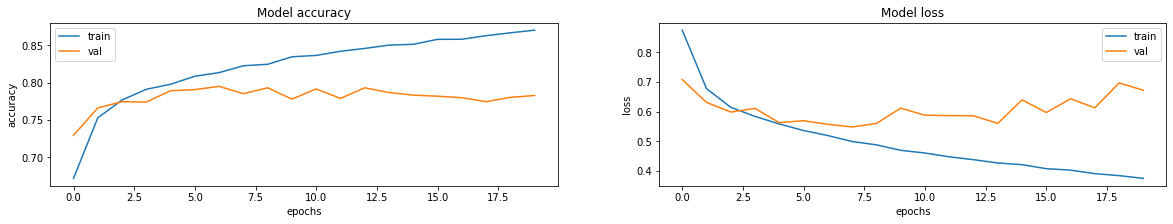

In [26]:
cnn_stats()

#### Fine-tuning partiel de VGG16

128/128 [==============================] - 15s 88ms/step - loss: 0.3306 - accuracy: 0.8848


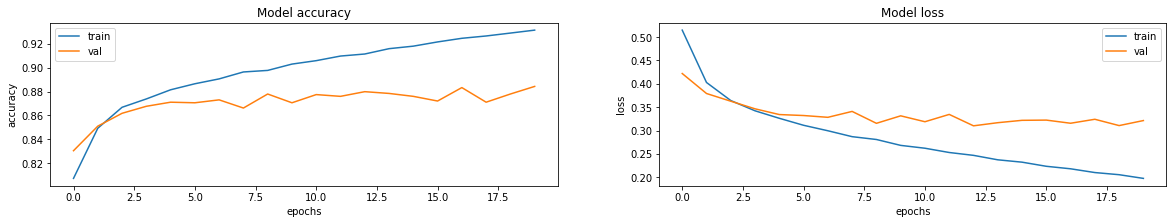

In [27]:
vgg_16_finetuned_stats()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.041s...
[t-SNE] Computed neighbors for 2048 samples in 2.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 11.079871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.823463
[t-SNE] KL divergence after 2000 iterations: 2.170955


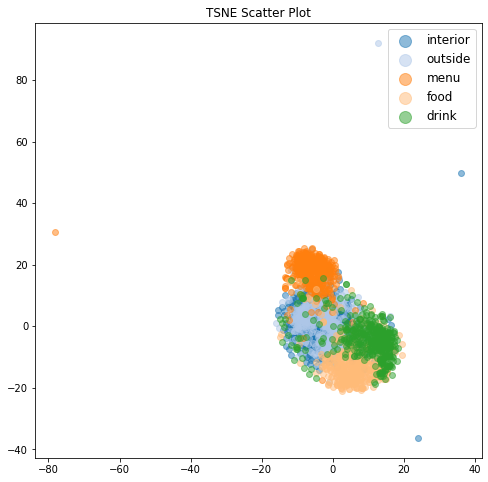

In [28]:
tsne(vgg_16_finetuned)

#### Fine-tuning complet de VGG16

128/128 [==============================] - 11s 87ms/step - loss: 0.2543 - accuracy: 0.9204


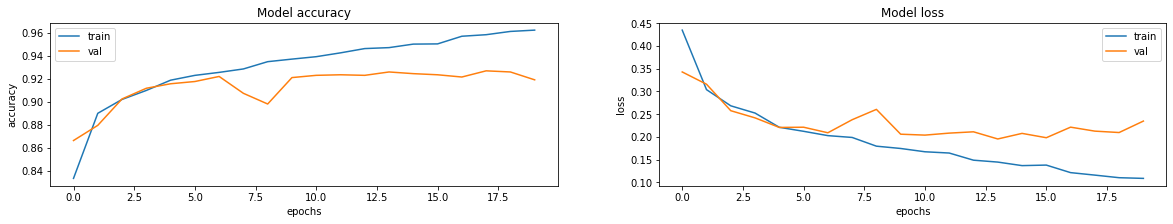

In [29]:
vgg_16_fully_finetuned_stats()

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.041s...
[t-SNE] Computed neighbors for 2048 samples in 2.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 22.825990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.090462
[t-SNE] KL divergence after 2000 iterations: 1.112474


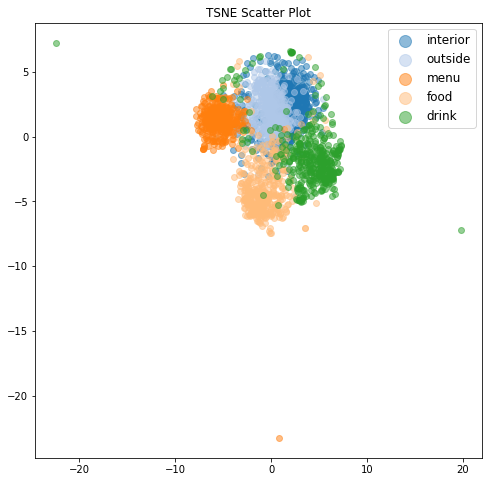

In [30]:
tsne(vgg_16_fully_finetuned, pp=200, lr=2)

#### Visualisation des erreurs

In [43]:
def get_errors(model_name):
    print(f"{model_name} prediction statistics\n")
    col = model_name + "_label"
    for lbl_id, lbl in enumerate(lbls):
        print(f"{lbl} prediction errors:")
        tmp = test_df[test_df["label"]==lbl_id]
        tmp2 = tmp[tmp[col]==lbl_id]
        s = round(100 * tmp2.shape[0] / tmp.shape[0], 2)
        print(f"  Right {s}%")
        for inner_lbl_id, inner_lbl in enumerate(lbls):
            if inner_lbl != lbl:
                tmp2 = tmp[tmp[col]==inner_lbl_id]
                s = round(100 * tmp2.shape[0] / tmp.shape[0], 2)
                print(f"  Mistaken as {inner_lbl} {s}%")
        print('\n')
    print('-'*50+'\n')
                
for mn in ["cnn", "vgg16_finetuned", "vgg_16_fully_finetuned"]:
    get_errors(mn)

cnn prediction statistics

interior prediction errors:
  Right 81.31%
  Mistaken as outside 8.01%
  Mistaken as menu 2.67%
  Mistaken as food 2.67%
  Mistaken as drink 5.34%


outside prediction errors:
  Right 69.21%
  Mistaken as interior 23.63%
  Mistaken as menu 2.39%
  Mistaken as food 1.19%
  Mistaken as drink 3.58%


menu prediction errors:
  Right 91.59%
  Mistaken as interior 4.81%
  Mistaken as outside 1.68%
  Mistaken as food 0.72%
  Mistaken as drink 1.2%


food prediction errors:
  Right 82.41%
  Mistaken as interior 8.29%
  Mistaken as outside 1.51%
  Mistaken as menu 0.25%
  Mistaken as drink 7.54%


drink prediction errors:
  Right 68.49%
  Mistaken as interior 15.14%
  Mistaken as outside 4.22%
  Mistaken as menu 1.99%
  Mistaken as food 10.17%


--------------------------------------------------

vgg16_finetuned prediction statistics

interior prediction errors:
  Right 85.68%
  Mistaken as outside 5.1%
  Mistaken as menu 1.21%
  Mistaken as food 2.67%
  Mistaken as d